# Exercício 1 - Previsão de Série Temporal com Lógica Fuzzy

**Dataset**: Apple Stock (AAPL) - a1621595_data.csv

**Objetivo**: Implementar um Sistema de Inferência Fuzzy (SIF) usando o método de Wang & Mendel para prever valores futuros de uma série temporal.

## Requisitos do Enunciado:
1. ✅ Realizar previsão **um passo à frente** usando SIF
2. ⚠️ Fazer **passo a passo manual** da extração de regras para os 10 primeiros registros
3. ✅ Variar número de conjuntos fuzzy, tamanho de janela, operações de interseção, implicação e defuzzificação

In [21]:
import os
import sys
sys.path.append("../..")
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skfuzzy import control as ctrl
import pandas as pd
from pathlib import Path

from src.fuzzy_utils import *
from src.rule_generation import *

In [22]:
TS_DATA_FILENAME = 'a1621595_data.csv'
FILE_PATH = Path.cwd().parent.parent / 'data' / TS_DATA_FILENAME

In [23]:
window_size = 2
num_fuzzy_sets = 3
metodo_defuzzificacao = defuzzificacao_centroid
operacao_intersecao = operacao_intersecao_min
operacao_implicacao = implicacao_prod

In [24]:
print("Carregando dados...")
try:
    df_raw = pd.read_csv(FILE_PATH, header=0)
    df_clean = df_raw.iloc[2:].copy()
    if 'Close' in df_clean.columns:
        series_data = pd.to_numeric(df_clean['Close'])
    else:
        series_data = pd.to_numeric(df_clean.iloc[:, 1])
        
    series_data = series_data.reset_index(drop=True)
    # Se a série for muito grande, o Wang & Mendel em Python puro vai demorar muito.
    #series_data = series_data.iloc[-300:] 
    print(f"Dados carregados e limpos. Total de amostras: {len(series_data)}")
    
except Exception as e:
    print(f"Erro ao ler o arquivo: {e}")

Carregando dados...
Dados carregados e limpos. Total de amostras: 283


## 2. Lags Preparation

In [25]:
df = pd.DataFrame(series_data.values, columns=['target'])

# Cria as variáveis defasadas (lags)
# O enunciado pede para testar janelas. Aqui estamos usando 3 lags como exemplo inicial.
NUM_LAGS = 3
for i in range(1, NUM_LAGS + 1):
    df[f'lag_{i}'] = df['target'].shift(i)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
# Inverte as colunas para ficar na ordem: [lag_N, ..., lag_1, target]
# Isso é importante para que o antecedente venha antes do consequente na criação das regras
df = df.iloc[:, ::-1]

## 3. Universe Definition and Fuzzy Set

In [26]:
# Definindo min e max para o universo de discurso
min_value = df.min().min()
max_value = df.max().max()
margin = (max_value - min_value) * 0.1  # 10% de margem
universe = np.linspace(min_value - margin, max_value + margin, 100)

# Criando as variáveis do skfuzzy
variable_list = []
for name in df.columns:
    if name != 'target':
        # Antecedentes (Entradas)
        var = ctrl.Antecedent(universe, name)
    else:
        # Consequente (Saída)
        var = ctrl.Consequent(universe, name)

    # Criação automática dos conjuntos (automf).
    # O enunciado pede para variar isso (3, 5, 7, 9...). Começamos com 5.
    var.automf(5)
    variable_list.append(var)

## 4. Rules Generation (train)

In [27]:
split_idx = int(len(df) * 0.8)
df_train = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]

print(f"Gerando regras com {len(df_train)} amostras de treino... (Aguarde)")

# Chama a função do arquivo rule_generation.py
# O parâmetro '1' indica que a última coluna é a saída
fuzzy_system = create_fuzzy_system(df_train, variable_list, operacao_intersecao,operacao_implicacao,1)
fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_system)

Gerando regras com 224 amostras de treino... (Aguarde)


In [28]:
print("="*80)
print("EXTRAÇÃO MANUAL DE REGRAS - MÉTODO DE WANG & MENDEL")
print("="*80)
print(f"\nUtilizando os primeiros 10 registros do conjunto de treino:\n")

# Pega os 10 primeiros registros do treino
manual_df = df_train.head(10)

print("\n📊 DADOS DE ENTRADA:")
print(manual_df.to_string())

print("\n\n🔍 PASSO A PASSO DA EXTRAÇÃO DE REGRAS:\n")

manual_rules = []
for idx, row in manual_df.iterrows():
    print(f"\n{'─'*80}")
    print(f"REGISTRO #{idx + 1}:")
    print(f"{'─'*80}")
    
    # Mostra os valores de entrada
    input_values = []
    for col in df_train.columns[:-1]:
        val = row[col]
        input_values.append(f"{col}={val:.4f}")
    print(f"  Entradas: {', '.join(input_values)}")
    print(f"  Saída (target): {row['target']:.4f}")
    
    # Fuzzificação: encontra o conjunto com maior pertinência para cada variável
    rule_parts = []
    membership_degrees = []
    
    for var_idx, var in enumerate(variable_list):
        value = row[df_train.columns[var_idx]]
        label_max, pertinence_max = select_higher_membership(var, value)
        
        if var.label == 'target':
            print(f"\n  ➜ CONSEQUENTE: {var.label} = {label_max} (μ = {pertinence_max:.4f})")
        else:
            print(f"  ➜ {var.label} = {label_max} (μ = {pertinence_max:.4f})")
            
        rule_parts.append(f"{var.label} is {label_max}")
        membership_degrees.append(pertinence_max)
    
    # Grau da regra (produto das pertinências)
    rule_degree = np.prod(membership_degrees)
    
    # Formata a regra
    antecedents = " AND ".join(rule_parts[:-1])
    consequent = rule_parts[-1]
    
    print(f"\n  📋 REGRA GERADA:")
    print(f"     IF {antecedents}")
    print(f"     THEN {consequent}")
    print(f"     (Grau da regra: {rule_degree:.6f})")
    
    manual_rules.append({
        'registro': idx + 1,
        'antecedentes': antecedents,
        'consequente': consequent,
        'grau': rule_degree
    })

print("\n\n" + "="*80)
print("RESUMO DAS REGRAS EXTRAÍDAS (10 primeiros registros)")
print("="*80)

for r in manual_rules:
    print(f"\nR{r['registro']}: IF {r['antecedentes']} THEN {r['consequente']}")
    print(f"     Grau: {r['grau']:.6f}")

print("\n\n⚠️  NOTA: O método de Wang & Mendel filtra regras conflitantes,")
print("    mantendo apenas aquela com MAIOR grau de pertinência.")
print("    Isso será feito automaticamente na função create_fuzzy_system().")

EXTRAÇÃO MANUAL DE REGRAS - MÉTODO DE WANG & MENDEL

Utilizando os primeiros 10 registros do conjunto de treino:


📊 DADOS DE ENTRADA:
      lag_3     lag_2     lag_1    target
0  0.590946  0.610009  0.594699  0.586293
1  0.610009  0.594699  0.586293  0.579238
2  0.594699  0.586293  0.579238  0.574735
3  0.586293  0.579238  0.574735  0.596649
4  0.579238  0.574735  0.596649  0.675152
5  0.574735  0.596649  0.675152  0.682958
6  0.596649  0.675152  0.682958  0.716730
7  0.675152  0.682958  0.716730  0.711777
8  0.682958  0.716730  0.711777  0.712528
9  0.716730  0.711777  0.712528  0.719582


🔍 PASSO A PASSO DA EXTRAÇÃO DE REGRAS:


────────────────────────────────────────────────────────────────────────────────
REGISTRO #1:
────────────────────────────────────────────────────────────────────────────────
  Entradas: lag_3=0.5909, lag_2=0.6100, lag_1=0.5947
  Saída (target): 0.5863
  ➜ lag_3 = poor (μ = 0.6249)
  ➜ lag_2 = poor (μ = 0.5759)
  ➜ lag_1 = poor (μ = 0.6153)

  ➜ CONSEQUENTE:

## 4.1 Extração Manual de Regras (10 primeiros registros)

**Requisito 2 do enunciado**: Demonstrar o processo manual de extração de regras fuzzy usando o método de Wang & Mendel para os 10 primeiros pares entrada/saída.

## 4. Prediction and Results

Realizando previsões...
RMSE (Teste): 0.2708
RMSE (Teste): 0.2708


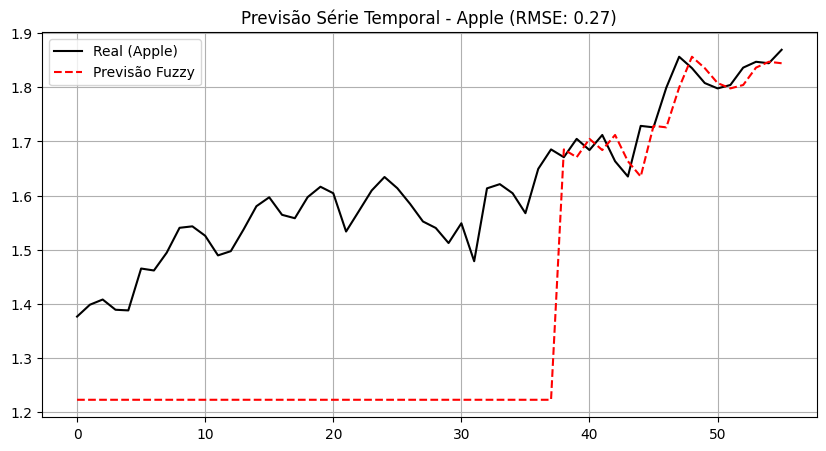

In [29]:
print("Realizando previsões...")

predictions = []
reals = []

# Vamos prever sobre o conjunto de TESTE
# Iteramos linha por linha do df_test
for i in range(len(df_test)):
    row = df_test.iloc[i]

    # Passa as entradas para o simulador
    # row.index[:-1] pega os nomes das colunas de entrada (lags)
    for col_name in df_test.columns[:-1]:
        fuzzy_sim.input[col_name] = row[col_name]

    try:
        fuzzy_sim.compute()
        result = fuzzy_sim.output['target']
    except:
        # Se não ativar nenhuma regra, mantemos o valor anterior (persistência) ou média
        result = row[df_test.columns[-2]]  # Pega o lag_1 como chute

    predictions.append(result)
    reals.append(row['target'])

# Converte para array
y_pred = np.array(predictions)
y_real = np.array(reals)

# Calcula erro
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
print(f"RMSE (Teste): {rmse:.4f}")

# Plota gráfico
plt.figure(figsize=(10, 5))
plt.plot(y_real, label='Real (Apple)', color='black')
plt.plot(y_pred, label='Previsão Fuzzy', color='red', linestyle='--')
plt.title(f'Previsão Série Temporal - Apple (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True)
plt.show()

# Se quiser ver as regras geradas:
# for rule in fuzzy_system.rules:
#     print(rule)

In [30]:
# =============================================================================
# CONFIGURAÇÃO DOS TESTES
# =============================================================================
lags_to_test = [3, 5, 8, 12]       # Tamanhos de janela para testar
sets_to_test = [3, 5, 7, 9]        # Quantidade de conjuntos fuzzy
results = []                       # Lista para guardar os resultados

# Pega coluna Close
if 'Close' in df_clean.columns:
    full_data = pd.to_numeric(df_clean['Close']).reset_index(drop=True)
else:
    full_data = pd.to_numeric(df_clean.iloc[:, 1]).reset_index(drop=True)

# Limita tamanho para ser rápido (pode aumentar depois para o relatório final)
# full_data = full_data.iloc[-500:].reset_index(drop=True)

print(f"Iniciando bateria de testes com {len(full_data)} amostras...\n")

Iniciando bateria de testes com 283 amostras...



In [31]:

# =============================================================================
# BATERIA DE TESTES OTIMIZADA
# =============================================================================
# REDUZINDO OS TESTES para evitar travamentos
lags_to_test = [2, 3, 5]           # Tamanhos de janela (reduzido)
sets_to_test = [3, 5, 7]           # Quantidade de conjuntos fuzzy (removido 9)
results = []                        # Lista para guardar os resultados

# Carrega dados
filename = FILE_PATH
df_raw = pd.read_csv(filename, header=0)
df_clean = df_raw.iloc[2:].copy()

if 'Close' in df_clean.columns:
    full_data = pd.to_numeric(df_clean['Close']).reset_index(drop=True)
else:
    full_data = pd.to_numeric(df_clean.iloc[:, 1]).reset_index(drop=True)

print(f"Iniciando bateria de testes com {len(full_data)} amostras...")
print(f"Configurações: {len(lags_to_test)} janelas × {len(sets_to_test)} conjuntos = {len(lags_to_test)*len(sets_to_test)} testes\n")

# =============================================================================
# LOOP DE TESTES AUTOMÁTICO
# =============================================================================
for n_lags in lags_to_test:
    for n_sets in sets_to_test:
        print(f"Testando: Lags={n_lags}, Conjuntos={n_sets}...", end=" ")

        # 1. Preparar Lags
        df = pd.DataFrame(full_data.values, columns=['target'])
        for i in range(1, n_lags + 1):
            df[f'lag_{i}'] = df['target'].shift(i)
        df.dropna(inplace=True)
        df = df.iloc[:, ::-1]  # Reordenar

        # 2. Divisão Treino/Teste (80/20)
        split_idx = int(len(df) * 0.8)
        df_train = df.iloc[:split_idx]
        df_test = df.iloc[split_idx:]

        # 3. Definir Universo e Variáveis
        min_val = df.min().min()
        max_val = df.max().max()
        universe = np.linspace(min_val, max_val, 100)

        variable_list = []
        custom_names = [f'MF{i}' for i in range(n_sets)]

        for name in df.columns:
            if name != 'target':
                var = ctrl.Antecedent(universe, name)
            else:
                var = ctrl.Consequent(universe, name)
            var.automf(n_sets, names=custom_names)
            variable_list.append(var)

        # 4. Gerar Regras (Wang & Mendel) - AGORA COM FILTRAGEM!
        try:
            fuzzy_system = create_fuzzy_system(
                df_train, variable_list, 
                operacao_intersecao, operacao_implicacao, 1
            )
            fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_system)

            # 5. Previsão
            predictions = []
            reals = []

            for idx in range(len(df_test)):
                row = df_test.iloc[idx]
                for col in df_test.columns[:-1]:
                    fuzzy_sim.input[col] = row[col]

                try:
                    fuzzy_sim.compute()
                    res = fuzzy_sim.output['target']
                except:
                    res = row[df_test.columns[-2]]  # Fallback

                predictions.append(res)
                reals.append(row['target'])

            # 6. Calcular Erro
            rmse = np.sqrt(mean_squared_error(reals, predictions))
            
            # Conta número de regras corretamente (RuleOrderGenerator não tem len)
            num_rules = len(list(fuzzy_system.rules))
            
            print(f"✓ RMSE = {rmse:.4f} ({num_rules} regras)")

            results.append({
                'Lags': n_lags,
                'Conjuntos': n_sets,
                'RMSE': rmse,
                'N_Regras': num_rules
            })

        except Exception as e:
            print(f"✗ Erro: {str(e)[:50]}...")

# =============================================================================
# EXIBIR RESULTADOS
# =============================================================================
results_df = pd.DataFrame(results)
if not results_df.empty:
    results_df = results_df.sort_values(by='RMSE', ascending=True)
    print("\n" + "="*80)
    print("📊 RANKING DAS MELHORES CONFIGURAÇÕES")
    print("="*80)
    print(results_df.to_string(index=False))
    print("\n🏆 MELHOR CONFIGURAÇÃO:")
    best = results_df.iloc[0]
    print(f"   Lags: {best['Lags']}, Conjuntos: {best['Conjuntos']}")
    print(f"   RMSE: {best['RMSE']:.4f}, Regras: {best['N_Regras']}")
else:
    print("\n⚠️  Nenhum teste foi concluído com sucesso.")


Iniciando bateria de testes com 283 amostras...
Configurações: 3 janelas × 3 conjuntos = 9 testes

Testando: Lags=2, Conjuntos=3... ✓ RMSE = 0.4097 (224 regras)
Testando: Lags=2, Conjuntos=5... ✓ RMSE = 0.4097 (224 regras)
Testando: Lags=2, Conjuntos=5... ✓ RMSE = 0.2722 (224 regras)
Testando: Lags=2, Conjuntos=7... ✓ RMSE = 0.2722 (224 regras)
Testando: Lags=2, Conjuntos=7... ✓ RMSE = 0.1872 (224 regras)
Testando: Lags=3, Conjuntos=3... ✓ RMSE = 0.1872 (224 regras)
Testando: Lags=3, Conjuntos=3... ✓ RMSE = 0.4129 (224 regras)
Testando: Lags=3, Conjuntos=5... ✓ RMSE = 0.4129 (224 regras)
Testando: Lags=3, Conjuntos=5... ✓ RMSE = 0.2734 (224 regras)
Testando: Lags=3, Conjuntos=7... ✓ RMSE = 0.2734 (224 regras)
Testando: Lags=3, Conjuntos=7... ✓ RMSE = 0.1880 (224 regras)
Testando: Lags=5, Conjuntos=3... ✓ RMSE = 0.1880 (224 regras)
Testando: Lags=5, Conjuntos=3... ✓ RMSE = 0.4129 (222 regras)
Testando: Lags=5, Conjuntos=5... ✓ RMSE = 0.4129 (222 regras)
Testando: Lags=5, Conjuntos=5... 

Retreinando modelo com a melhor configuração:
  • Lags: 5
  • Conjuntos Fuzzy: 7

Gerando regras...
Realizando previsões no conjunto de TESTE...

Realizando previsões no conjunto de TESTE...

📊 RESULTADOS NO CONJUNTO DE TESTE:
   RMSE: 0.1154
   MAE:  0.0971
📊 RESULTADOS NO CONJUNTO DE TESTE:
   RMSE: 0.1154
   MAE:  0.0971
   Regras: 222
   Regras: 222


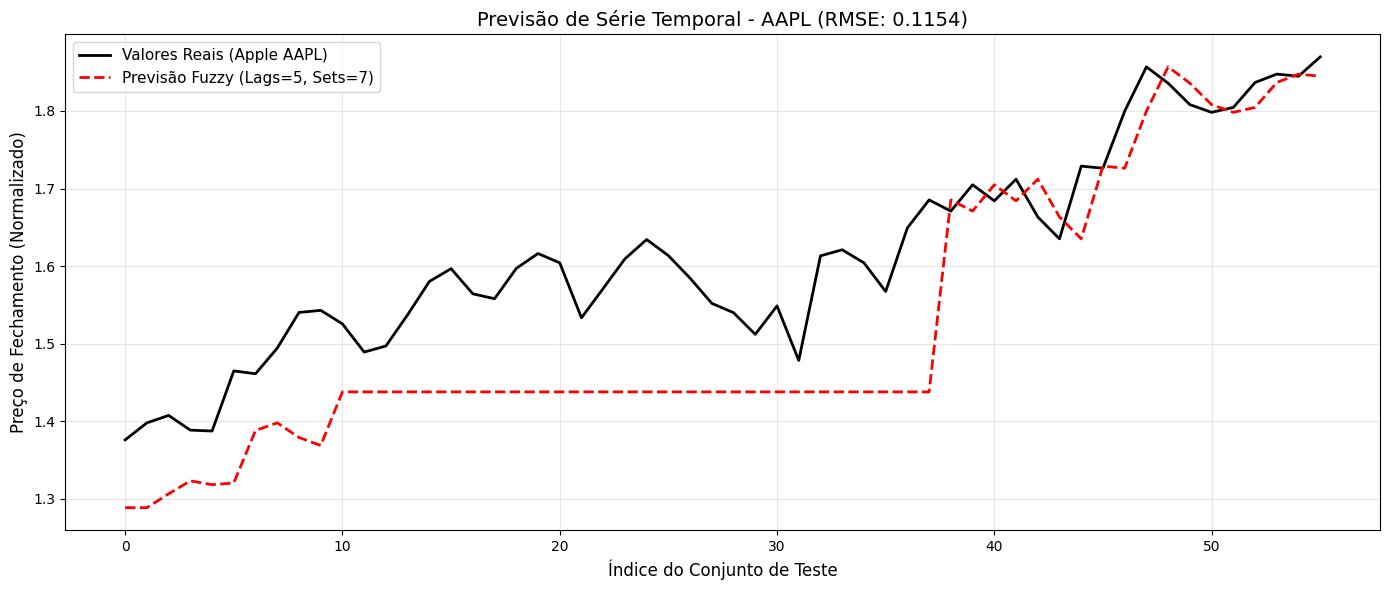

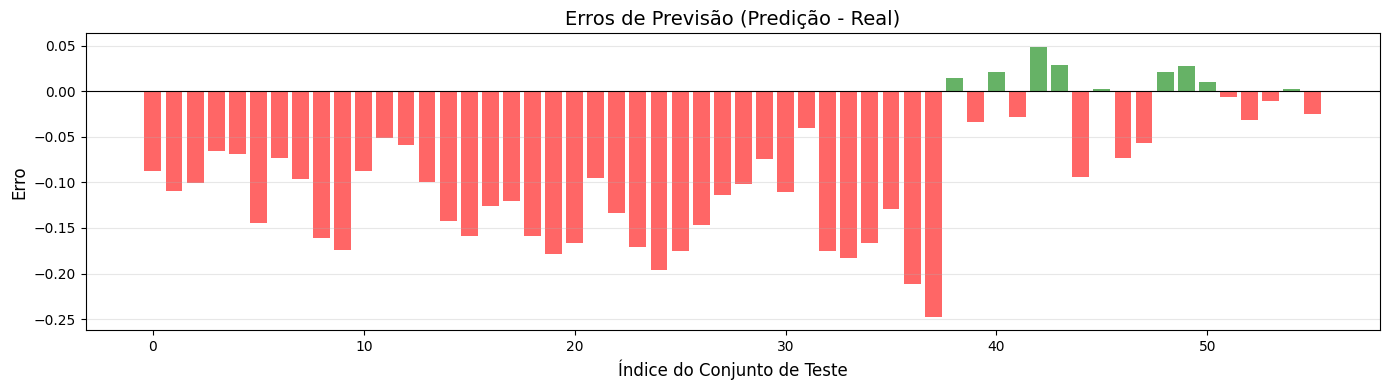

In [32]:
# Usando a MELHOR configuração encontrada nos testes
BEST_LAGS = 5
BEST_SETS = 7

print(f"Retreinando modelo com a melhor configuração:")
print(f"  • Lags: {BEST_LAGS}")
print(f"  • Conjuntos Fuzzy: {BEST_SETS}\n")

# 1. Preparar dados com a melhor janela
df_best = pd.DataFrame(full_data.values, columns=['target'])
for i in range(1, BEST_LAGS + 1):
    df_best[f'lag_{i}'] = df_best['target'].shift(i)
df_best.dropna(inplace=True)
df_best = df_best.iloc[:, ::-1]

# 2. Divisão treino/teste
split_idx = int(len(df_best) * 0.8)
train_best = df_best.iloc[:split_idx]
test_best = df_best.iloc[split_idx:]

# 3. Criar variáveis fuzzy
min_val = df_best.min().min()
max_val = df_best.max().max()
universe_best = np.linspace(min_val, max_val, 100)

vars_best = []
names_best = [f'MF{i}' for i in range(BEST_SETS)]

for name in df_best.columns:
    if name != 'target':
        var = ctrl.Antecedent(universe_best, name)
    else:
        var = ctrl.Consequent(universe_best, name)
    var.automf(BEST_SETS, names=names_best)
    vars_best.append(var)

# 4. Treinar sistema fuzzy
print("Gerando regras...")
sys_best = create_fuzzy_system(train_best, vars_best, operacao_intersecao, operacao_implicacao, 1)
sim_best = ctrl.ControlSystemSimulation(sys_best)

# 5. Fazer previsões
print("Realizando previsões no conjunto de TESTE...\n")
predictions_best = []
reals_best = []

for idx in range(len(test_best)):
    row = test_best.iloc[idx]
    for col in test_best.columns[:-1]:
        sim_best.input[col] = row[col]
    
    try:
        sim_best.compute()
        pred = sim_best.output['target']
    except:
        pred = row[test_best.columns[-2]]
    
    predictions_best.append(pred)
    reals_best.append(row['target'])

y_pred_best = np.array(predictions_best)
y_real_best = np.array(reals_best)

# 6. Calcular métricas
rmse_best = np.sqrt(mean_squared_error(y_real_best, y_pred_best))
mae_best = np.mean(np.abs(y_real_best - y_pred_best))

print(f"📊 RESULTADOS NO CONJUNTO DE TESTE:")
print(f"   RMSE: {rmse_best:.4f}")
print(f"   MAE:  {mae_best:.4f}")
print(f"   Regras: {len(list(sys_best.rules))}")

# 7. Plotar gráfico
plt.figure(figsize=(14, 6))
plt.plot(y_real_best, label='Valores Reais (Apple AAPL)', color='black', linewidth=2)
plt.plot(y_pred_best, label=f'Previsão Fuzzy (Lags={BEST_LAGS}, Sets={BEST_SETS})', 
         color='red', linestyle='--', linewidth=2)
plt.title(f'Previsão de Série Temporal - AAPL (RMSE: {rmse_best:.4f})', fontsize=14)
plt.xlabel('Índice do Conjunto de Teste', fontsize=12)
plt.ylabel('Preço de Fechamento (Normalizado)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. Gráfico de erros
plt.figure(figsize=(14, 4))
errors = y_pred_best - y_real_best
plt.bar(range(len(errors)), errors, color=['green' if e >= 0 else 'red' for e in errors], alpha=0.6)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.title('Erros de Previsão (Predição - Real)', fontsize=14)
plt.xlabel('Índice do Conjunto de Teste', fontsize=12)
plt.ylabel('Erro', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 5. Visualização com a Melhor Configuração

Agora vamos visualizar as previsões usando o **melhor modelo** encontrado nos testes.